<a href="https://colab.research.google.com/github/Nathan-Levy/Traffic-Flow-Prediction-in-Urban-Areas/blob/main/Emirates_Traffic_Matchdays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow import keras

In [38]:
emirates_detector = pd.read_csv('utd19_emirates_part_1.csv')

In [39]:
emirates_detector['day'] = pd.to_datetime(emirates_detector['day'])

emirates_detector['datetime'] = emirates_detector['day'] + pd.to_timedelta(emirates_detector['interval'], unit='s')

emirates_detector.set_index("datetime", inplace=True)

# Keep only the relevant column
time_flow = emirates_detector[['flow']]

print(time_flow)

                           flow
datetime                       
2015-10-01 00:00:00   96.000000
2015-10-01 00:05:00  108.000000
2015-10-01 00:10:00   75.000000
2015-10-01 00:15:00   96.000000
2015-10-01 00:20:00   48.000000
...                         ...
2016-05-22 23:35:00   24.857142
2016-05-22 23:40:00   45.000000
2016-05-22 23:45:00    0.000000
2016-05-22 23:50:00   15.000000
2016-05-22 23:55:00   15.000000

[3891 rows x 1 columns]


In [40]:
# Normalise
scaler = MinMaxScaler()
flow_normalised = scaler.fit_transform(time_flow)

In [41]:
# Train and validation split

train = len(flow_normalised)*0.8
X_train, X_val, = flow_normalised[:int(train)], flow_normalised[int(train):]

In [42]:
def create_dataset(dataset, look_back):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 12
X_train, y_train = create_dataset(X_train, look_back)
X_val, y_val = create_dataset(X_val, look_back)

In [43]:
# [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

In [44]:
input_layer = keras.layers.Input(shape=(look_back, 1))
encoded = keras.layers.LSTM(64, activation='relu', return_sequences=True)(input_layer)
encoded = keras.layers.LSTM(32, activation='relu', return_sequences=False)(encoded)

# Decoder
decoded = keras.layers.Dense(64, activation='relu')(encoded)
decoded = keras.layers.Dense(look_back, activation='linear')(decoded)

# Autoencoder Model
autoencoder = keras.models.Model(inputs=input_layer, outputs=decoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 12, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 12, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 12)                  │             780 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,204 (125.80 KB)

 Trainable params: 32,204 (125.80 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=20, validation_data=[X_val, X_val])

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0395 - val_loss: 0.0073
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0077 - val_loss: 0.0067
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0064 - val_loss: 0.0063
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0062 - val_loss: 0.0063
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0058 - val_loss: 0.0061
Epoch 6/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0055 - val_loss: 0.0059
Epoch 7/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0053 - val_loss: 0.0056
Epoch 8/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0051 - val_loss: 0.0055
Epoch 9/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0051 - val_loss: 0.0056
Epoch 10/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0050 - val_loss: 0.0055
Epoch 11/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0051 - val_loss: 0.0055
Epoch 12/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0

In [46]:
# Extract the encoder model
encoder = keras.models.Model(inputs=input_layer, outputs=encoded)

# Generate the encoded features
encoded_features = encoder.predict(X_train)
encoded_features_val = encoder.predict(X_val)

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [47]:
# Define the prediction model
prediction_model = keras.models.Sequential()
prediction_model.add(keras.layers.Dense(16, activation='relu', input_dim=encoded_features.shape[1]))
prediction_model.add(keras.layers.Dense(8, activation='relu'))
prediction_model.add(keras.layers.Dense(1, activation='linear'))

# Compile the prediction model
prediction_model.compile(optimizer='adam', loss='mse')

# Train the prediction model
prediction_model.fit(encoded_features, y_train, epochs=20, validation_data=(encoded_features_val, y_val))

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0172 - val_loss: 0.0095
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0108 - val_loss: 0.0090
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0097 - val_loss: 0.0089
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0095 - val_loss: 0.0090
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 6/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 7/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0095 - val_loss: 0.0094
Epoch 8/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0095 - val_loss: 0.0089
Epoch 9/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0096 - val_loss: 0.0090
Epoch 10/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093 - val_loss: 0.0089
Epoch 11/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0088 - val_loss: 0.0091
Epoch 12/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093 - val_loss: 0.0089


In [48]:
# Use the prediction model to make predictions
y_pred = prediction_model.predict(encoded_features_val)

# Inverse transform the predictions to the original scale
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


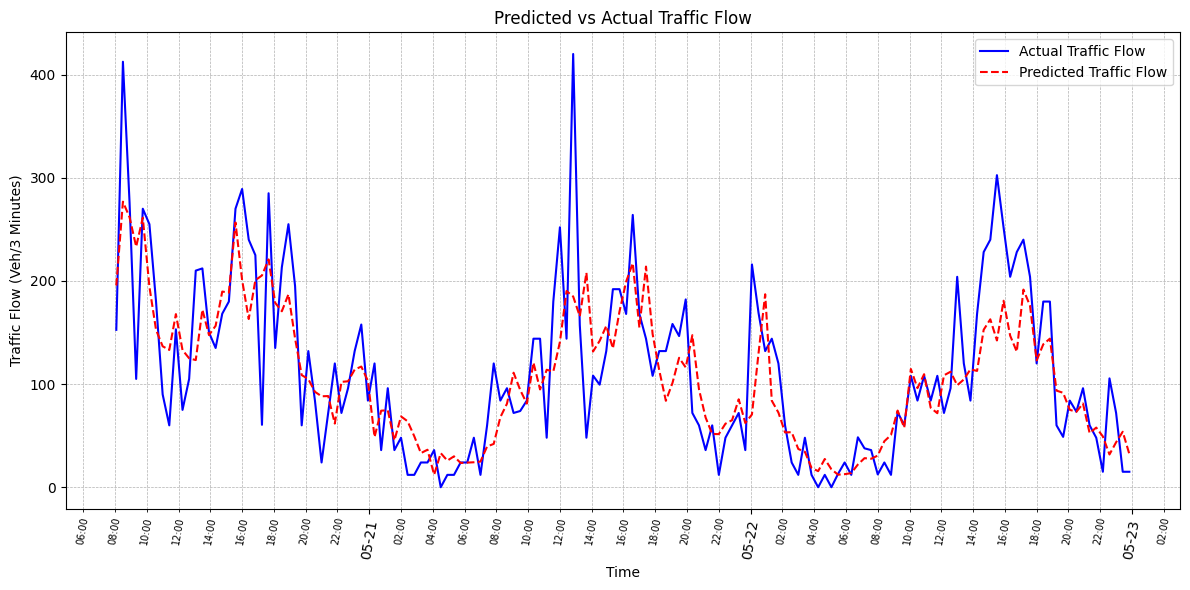

In [49]:
# timestamps from validation set.
timestamps = time_flow.index[-len(y_val):]

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Rescale the predicted values and actual values to their original scale
y_test_rescaled = scaler.inverse_transform(y_val.reshape(-1, 1))
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(timestamps[::5], y_test_rescaled[::5], label='Actual Traffic Flow', color='blue')
plt.plot(timestamps[::5], y_pred_rescaled[::5], label='Predicted Traffic Flow', color='red', linestyle='--')

# Format the x-axis
# Major locator for each day
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

# Minor locator for each hour
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(interval=2))
plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))

# Add grid lines for minor ticks to help visibility (optional)
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
plt.gca().tick_params(axis='x', which='minor', rotation=80, labelsize=7)  # Rotate and adjust minor ticks
plt.gca().tick_params(axis='x', which='major', labelsize=10)

plt.xlabel('Time')
plt.ylabel('Traffic Flow (Veh/3 Minutes)')
plt.title('Predicted vs Actual Traffic Flow')
plt.legend()
# Rotate the x-axis labels for better visibility (optional)
plt.xticks(rotation=80)

# Show the plot
plt.tight_layout()
plt.show()
